In [ ]:
!mkdir pictures
!mkdir mask

In [ ]:
!rm -r pictures
!rm -r mask

In [ ]:
import os
import json
import numpy as np
import skimage.draw
import cv2

# обработка и рисование изображений
import imageio.v2 as imageio
from PIL import Image

# рисование графиков
import matplotlib.pyplot as plt

# для создание модели
import tensorflow as tf

# Слои, которые потребуются
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose # транспонированная свертка
from tensorflow.keras.layers import concatenate # объединение тензоров

from tensorflow.keras.losses import binary_crossentropy # функция ошибки
from sklearn.model_selection import train_test_split # разделение данных на обучающее и проверочное множества

In [ ]:
IMAGE_FOLDER = "./pictures/"          # Путь до изображений
MASK_FOLOER = "./mask/"               # Путь куда будут сохраняться маски
PATH_ANNOTATION_JSON = 'sagital.json' # Путь до JSON файла

# Загрузить VIA экспортированный файл JSON
annotations = json.load(open(PATH_ANNOTATION_JSON, 'r'))
imgs = annotations["_via_img_metadata"]

for imgId in imgs:
    filename = imgs[imgId]['filename'] # Имя файла
    regions = imgs[imgId]['regions']   # Список регионов, который содержит region_attributes, 'shape_attributes'

    if len(regions) <= 0:
        continue

          # Путь к изображению
    image_path = os.path.join(IMAGE_FOLDER, filename)

          # Получение информации о ширине и высоте
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

          # Создаем пустую маску
    maskImage = np.zeros((height,width), dtype=np.uint8)

    for ipoly in range(len(regions)):
          # Удаляем первую отмеченную категорию, в этом примере отмечен только объект
      polygons = regions[ipoly]['shape_attributes'] # Координаты точек региона: 'x','y'
      class_region = regions[ipoly]['region_attributes'] # Класс региона: 'spinal canal',''

      countOfPoints = len(polygons['all_points_x'])
      points = [None] * countOfPoints
      for i in range(countOfPoints):
          x = int(polygons['all_points_x'][i])
          y = int(polygons['all_points_y'][i])
          points[i] = (x, y)
      contours = np.array(points)

          # Перекрашивание всех точек внутри контура
      if class_region.get('spinal canal'):
        for i in range(width):
            for j in range(height):
                if cv2.pointPolygonTest(contours, (i, j), False) > 0:
                      maskImage[j,i] = 2
      else:
        for i in range(width):
            for j in range(height):
                if cv2.pointPolygonTest(contours, (i, j), False) > 0:
                      maskImage[j,i] = 1

      # Сохрание маски
    savePath = MASK_FOLOER + filename
    cv2.imwrite(savePath, maskImage)

In [ ]:
# Блок кодера
def EncoderMiniBlock(inputs,
                     n_filters=32,
                     dropout_prob=0.3,
                     max_pooling=True):

    # Два сверточных слоя с инициализацией.
    conv = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)


    conv = BatchNormalization()(conv, training=False)


    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Если нужен пулинг
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    #выход блока
    else:
        next_layer = conv # выход блока

    # выход слоев до пулинга
    skip_connection = conv

    return next_layer, skip_connection

In [ ]:
# Блок декодера
def DecoderMiniBlock(prev_layer_input,
                     skip_layer_input,
                     n_filters=32):

    # Транспонированная свертка, для увеличения пространственного размера карты признаков в два раза
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),
                 strides=(2,2), # страйд 2,2 для увеличения размера в 2 раза
                 padding='same')(prev_layer_input)

    # Конкатенируем по каналам выход транспонированной свертки и выход блока кодера
    merge = concatenate([up, skip_layer_input], axis=3)

    # Два сверточных слоя с инициализацией.
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [ ]:
def UNetCompiled(input_size=(128, 128, 3),
                 n_filters=32,
                 n_classes=3):
     # Кодер
    # Блок 1 -> Блок 2(в 2 раза меньше) -> Блок 3 -> Блок 4 -> Блок 5 ->

    # Декодер
    # блок 6 принимает выход блока 5, и второй выход (т.е. до слоя субдискретизации) блока 4,
    # число фильтров в два раза меньше чем у блока 5, повышает размеры карты
    # блок 7 принимает выход блока 6, и второй выход блока 3, число фильтров в два раза меньше, повышает размеры карты
    # блок 8 принимает выход блока 7, и второй выход блока 2, число фильтров в два раза меньше, повышает размеры карты
    # блок 9 принимает выход блока 8, и второй выход блока 1, число фильтров в два раза меньше, повышает размеры карты
    # Вход в сеть определённого размера

    # Кодер
    # блок 1 принимает вход в сеть, число фильтров базовое, dropout нет, понижает размеры карты
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    # блок 2 принимает выход блока 1 (обратите внимание что блоки кодера возвращают два выхода),
    # число фильтров в два раза больше, dropout нет, понижает размеры карты
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    # блок 3 принимает выход блока 2, число фильтров еще в два раза больше, dropout нет, понижает размеры карты
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    # блок 4 принимает выход блока 3, число фильтров еще в два раза больше, dropout есть, понижает размеры карты
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    # блок 5 принимает выход блока 4, число фильтров еще в два раза больше, dropout есть, НЕ понижает размеры карты
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Декодер
    # блок 6 принимает выход блока 5, и второй выход (т.е. до слоя субдискретизации) блока 4,
    # число фильтров в два раза меньше чем у блока 5, повышает размеры карты
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    # блок 7 принимает выход блока 6, и второй выход блока 3, число фильтров в два раза меньше, повышает размеры карты
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    # блок 8 принимает выход блока 7, и второй выход блока 2, число фильтров в два раза меньше, повышает размеры карты
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    # блок 9 принимает выход блока 8, и второй выход блока 1, число фильтров в два раза меньше, повышает размеры карты
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # слой свертки без изменения размеров карты, число фильтров как у предыдущего блока
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    # слой свертки без изменения размеров карты, число фильтров по количеству классов
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Создаем модель из слоев
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
# Загрузка данных
def LoadData (path1, path2):
    """
    Принимает пути к директориям с 1-изображениями и 2-масками
    Возвращает два списка: пути к файлам изображения и масок
    """
    # читаем все файлы директории
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)
    # делаем список файлов
    orig_img = []
    mask_img = []
    for file in image_dataset:
        orig_img.append(file)
    for file in mask_dataset:
        mask_img.append(file)

    # Сортируем по имени
    orig_img.sort()
    mask_img.sort()

    return orig_img, mask_img

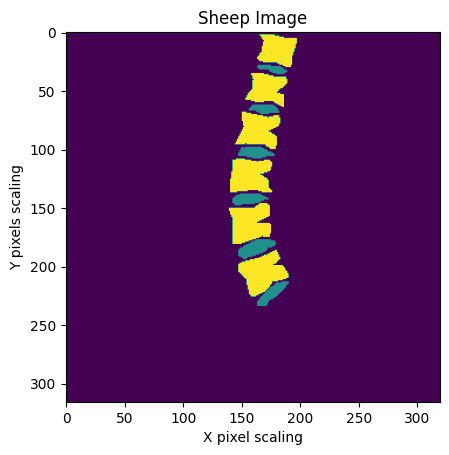

In [ ]:
url = './mask/' + '00629.PNG'
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

plt.title("Sheep Image")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")

image = mpimg.imread(url)
plt.imshow(image)
plt.show()

In [ ]:
# предобработка данных
def PreprocessData(img, # изображения
                   mask, # маски
                   target_shape_img, # требуемый размер изображения
                   target_shape_mask,#  требуемый размер маски
                   path1, # директория с изображениями
                   path2): # директория с масками
    """
    Изображения трехканальные. Маски одноканальные.
    """
    # требуемые размеры
    m = len(img)                     # число примеров
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask

    # Массивы для изображений и масок, измерение 0 - примеры.
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32) # изображения как числа с плавающей точкой
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32) # маски (они же классы) целые числа.

    # Изменяем размеры
    for file in img:
        # Обработка изображений (3 канала)
        index = img.index(file) # индекс в массиве
        path = os.path.join(path1, file) # путь к файлу изображения
        single_img = Image.open(path) # открываем и конвертируем в RGB
        single_img = single_img.resize((i_h,i_w)) # изменяем размер
        single_img = np.reshape(single_img,(i_h,i_w,i_c)) # нужные размеры массива
        single_img = single_img/255. # приводим диапазон значений пикселей к 0...1 в float32
        X[index] = single_img

        # Обработка масок (1 канал)
        single_mask_ind = mask[index] # индекс в массиве
        path = os.path.join(path2, single_mask_ind) # путь к файлу маски
        single_mask = Image.open(path) # открываем, конвертировать не надо, оно и так бинарное
        single_mask = single_mask.resize((m_h, m_w)) # изменяем размер
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c))  # нужные размеры массива
        single_mask = single_mask # нумерация классов должна начинаться с 0 (было 1,2)
        y[index] = single_mask
    return X, y

(316, 320)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 240 242 243 244 255

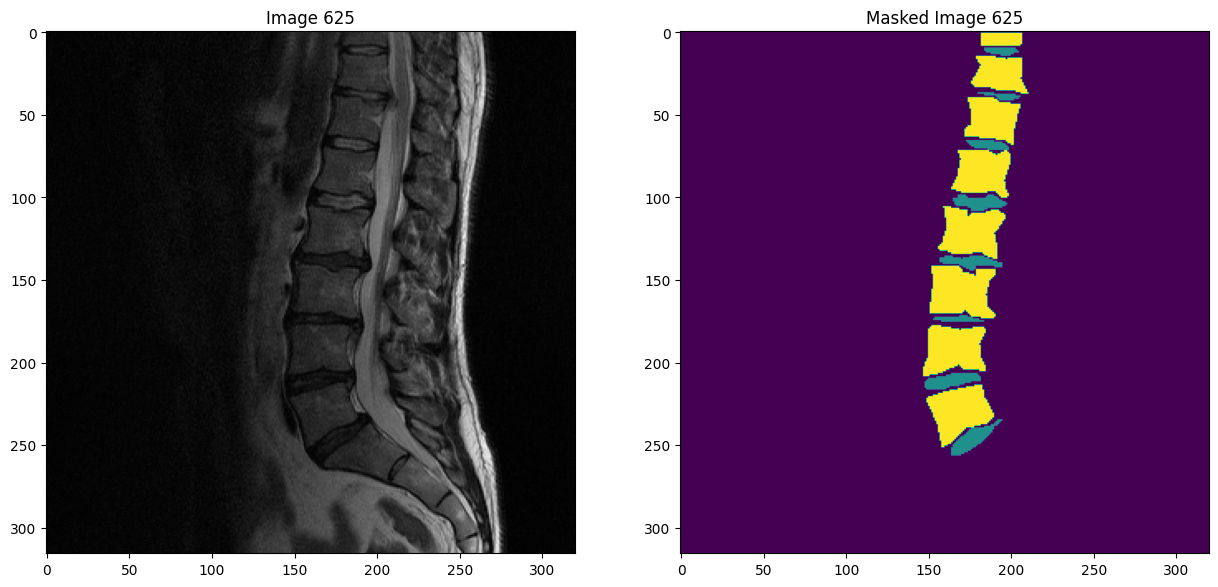

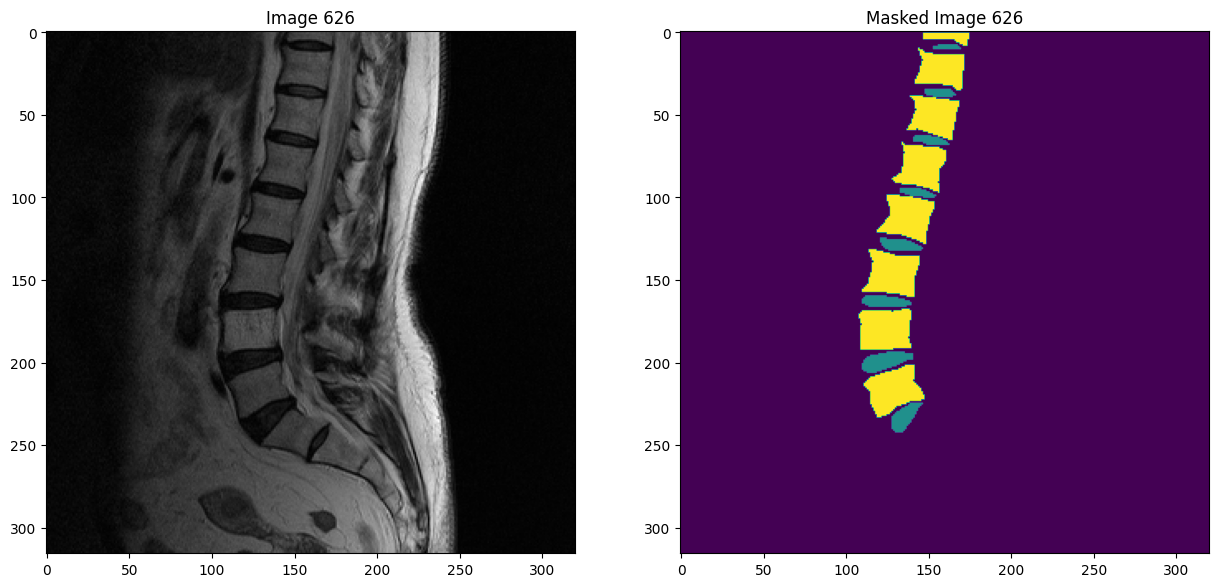

In [ ]:

# рисуем изображения и маски
start_img = 625 #
stop_img = 627
for i in range(start_img, stop_img):
    img_view  = imageio.imread(IMAGE_FOLDER + f'{i:05}.PNG') # путь к изображению
    mask_view = imageio.imread(MASK_FOLOER + f'{i:05}.PNG') # путь к его маске

    print(img_view.shape)
    print(np.unique(img_view))
    print(np.unique(mask_view))
    #print(mask_view.min(), mask_view.max())
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view, cmap='gray') # рисуем изображение
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view) # рисуем маску
    arr[1].set_title('Masked Image '+ str(i))

X Shape: (30, 256, 256, 1)
Y shape: (30, 256, 256, 1)
[0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196079 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.1882353  0.19215687 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568628 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313726 0.24705882 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.30980393 0.3137255  0.31764707 0.32156864 0.3254902
 0.32941177

Text(0.5, 1.0, 'Processed Masked Image ')

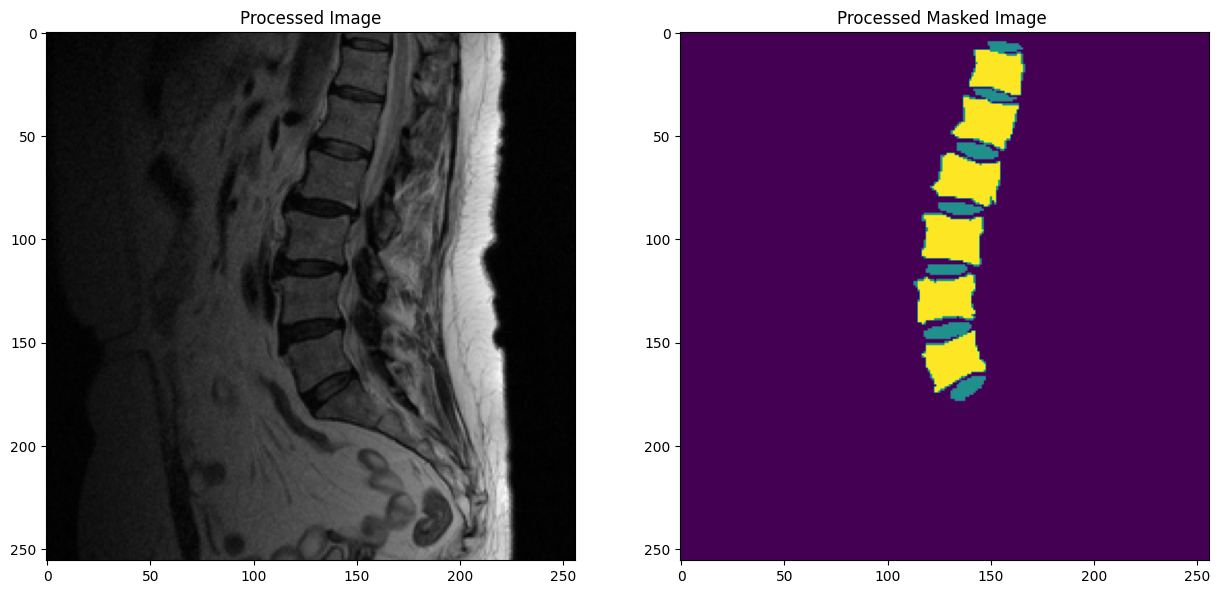

In [ ]:
target_shape_img = [256, 256, 1] # размер изображений
target_shape_mask = [256, 256, 1] # размер масок

img, mask = LoadData (IMAGE_FOLDER, MASK_FOLOER)

# обрабатываем
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, IMAGE_FOLDER, MASK_FOLOER)

#
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# Классы : фон, объект, контур
print(np.unique(X))
print(np.unique(y))

# отображаем обработанные изображения и маски
image_index = 0
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index], cmap = 'gray')
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)


In [ ]:
unet = UNetCompiled(input_size=(256,256,1), n_filters=16, n_classes=3)


In [ ]:
# посмотрим на сеть
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
# оптимизатор Adam, функция ошибки - кроссэнтропия которая применяет softmax к выходам сети, метрика - аккуратность
unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Обучаем
#results = unet.fit(X_train, y_train, batch_size=2, epochs=50, validation_data=(X_valid, y_valid))
results = unet.fit(X_train, y_train, batch_size=2, epochs=50, validation_data=(X_valid, y_valid))


Epoch 1/50
12/12 [==============================] - 29s 2s/step - loss: 0.9662 - accuracy: 0.6183 - val_loss: 0.4975 - val_accuracy: 0.9247
Epoch 2/50
12/12 [==============================] - 24s 2s/step - loss: 0.4110 - accuracy: 0.9279 - val_loss: 0.2735 - val_accuracy: 0.9337
Epoch 3/50
12/12 [==============================] - 21s 2s/step - loss: 0.2143 - accuracy: 0.9326 - val_loss: 0.1516 - val_accuracy: 0.9358
Epoch 4/50
12/12 [==============================] - 21s 2s/step - loss: 0.1915 - accuracy: 0.9334 - val_loss: 0.1812 - val_accuracy: 0.9360
Epoch 5/50
12/12 [==============================] - 20s 2s/step - loss: 0.2088 - accuracy: 0.9334 - val_loss: 0.1561 - val_accuracy: 0.9360
Epoch 6/50
12/12 [==============================] - 22s 2s/step - loss: 0.1659 - accuracy: 0.9334 - val_loss: 0.1466 - val_accuracy: 0.9360
Epoch 7/50
12/12 [==============================] - 20s 2s/step - loss: 0.1637 - accuracy: 0.9334 - val_loss: 0.1590 - val_accuracy: 0.9360
Epoch 8/50
12/12 [==

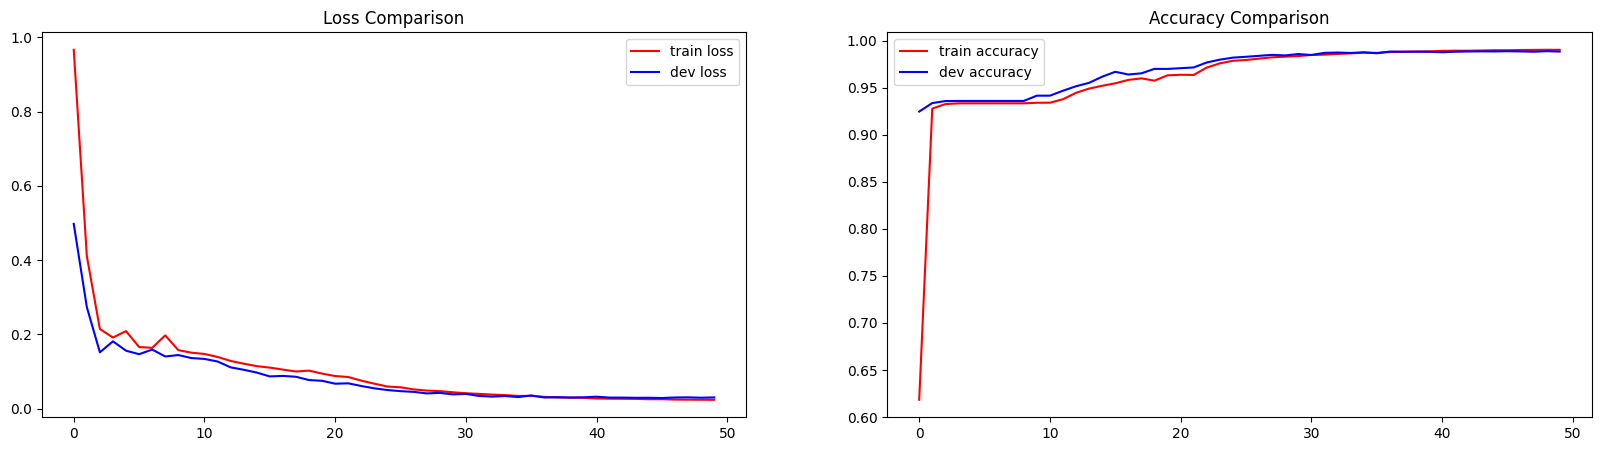

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

In [ ]:
# оценка качества сети
unet.evaluate(X_valid, y_valid)

1/1 [==============================] - 1s 1s/step - loss: 0.0302 - accuracy: 0.9884


[0.030184322968125343, 0.9884033203125]

In [ ]:
# рисуем
def VisualizeResults(index):
    img = X_valid[index] # изображение
    img = img[np.newaxis, ...] # добавляем измерение примеров
    pred_y = unet.predict(img) # маска
    pred_mask = tf.argmax(pred_y[0], axis=-1) #  максимальный класс
    pred_mask = pred_mask[..., tf.newaxis] # каналы
    # рисуем
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_valid[index], cmap='gray')
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0], cmap='gray')
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0], cmap='gray')
    arr[2].set_title('Predicted Masked Image ')

1/1 [==============================] - 0s 329ms/step


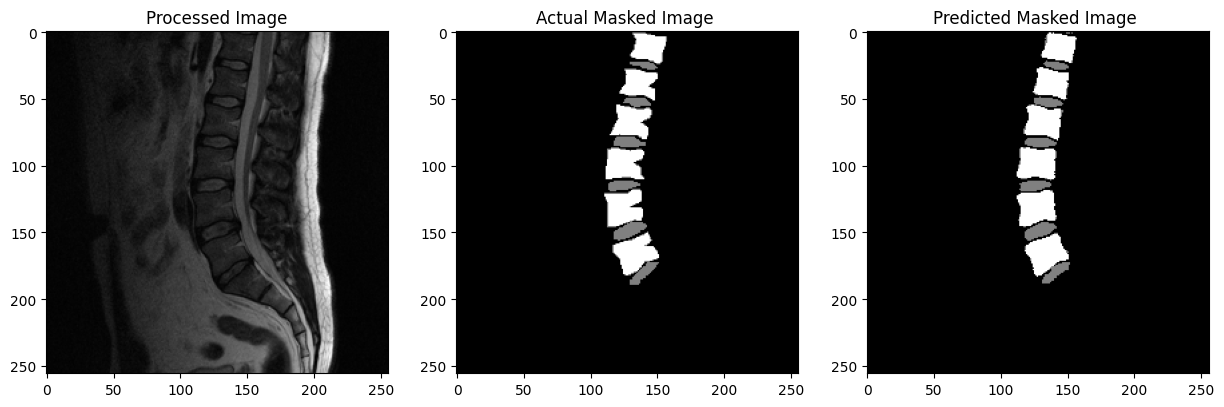

In [ ]:
# рисуем
index = 1
VisualizeResults(index)